In [124]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [125]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt

import torch

from latent_geometry.model.mnist_vae import (
    load_decoder,
    load_encoder,
)
from latent_geometry.viz.plotly import (
    plot_traces,
    draw_spiders,
    create_background_trace,
    _path_to_trace,
)
from latent_geometry.mapping import TorchModelMapping, Mapping
from latent_geometry.manifold import LatentManifold
from latent_geometry.metric import EuclideanMetric, PullbackMetric
from latent_geometry.path import ManifoldPath
from latent_geometry.data import load_mnist_dataset
from latent_geometry.utils import project, lift
import os

from typing import Union, Callable, Optional

from scipy.interpolate import splev, splprep
from functools import partial

In [126]:
# raise Exception("double check that we wont use already taken gpu ($ nvidia-smi)")
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [127]:
dataset = load_mnist_dataset(split="train")
images = torch.concat([img for img, _ in dataset])
labels = torch.tensor([label for _, label in dataset])
images.shape, labels.shape

(torch.Size([60000, 32, 32]), torch.Size([60000]))

In [128]:
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
model_name, latent_dim = "beta_10", 2

DEVICE = torch.device("cuda")
ENCODER = load_encoder(DEVICE, f"{model_name}_encoder.pt", latent_dim=latent_dim)
DECODER = load_decoder(DEVICE, f"{model_name}_decoder.pt", latent_dim=latent_dim)

z = ENCODER.sample(dataset[0][0].to(DEVICE)[None, :])
reconstruction = DECODER.decode(z)
reconstruction.shape

torch.Size([1, 1, 32, 32])

In [129]:
mus, sts = ENCODER(images.unsqueeze(1).to(DEVICE))
mus.shape, sts.shape

(torch.Size([60000, 2]), torch.Size([60000, 1]))

In [130]:
SOLVER_TOL = 0.001
ambient_metric = EuclideanMetric()
latent_mapping = TorchModelMapping(
    DECODER, (2,), (1, 32, 32), batch_size=10_000, call_fn=DECODER.decode
)
manifold_mnist = LatentManifold(
    latent_mapping, ambient_metric, solver_tol=SOLVER_TOL, bvp_n_mesh_nodes=2_000
)

In [131]:
mus, sts = ENCODER(images.unsqueeze(1).to(DEVICE))
mus.shape, sts.shape

(torch.Size([60000, 2]), torch.Size([60000, 1]))

In [132]:
def create_straight_path(from_: np.ndarray, to_: np.ndarray) -> ManifoldPath:
    def x_fun(t: float) -> np.ndarray:
        return from_ + (to_ - from_) * t

    return ManifoldPath(x_fun, manifold_mnist.metric)


def create_latent_path(from_: np.ndarray, theta: float, length: float) -> ManifoldPath:
    return manifold_mnist.path_given_direction(
        from_, np.array([np.cos(theta), np.sin(theta)]), length
    )


def create_geodesic_path(from_: np.ndarray, to_: np.ndarray) -> ManifoldPath:
    return manifold_mnist.geodesic(from_, to_)

In [133]:
def show_path_in_ambient(path: ManifoldPath, n_points: int = 9):
    fig, axes = plt.subplots(1, n_points, figsize=(1.5 * n_points, 2))
    for i in range(n_points):
        t = i / (n_points - 1)
        latent_dist = path.manifold_length(0, t)
        euclidean_dist = path.euclidean_length(0, t)
        ambient_dist = path.ambient_path.euclidean_length(0, t, dt=0.01)

        image = project(latent_mapping)(path(t)).reshape((32, 32))
        ax = axes[i]
        ax.imshow(image, cmap="gray")
        ax.set_title(
            (
                f"v: Euc: {euclidean_dist:.3f}, P-B: {latent_dist: .3f}\n"
                # f"d: Euc: {euclidean_dist_diff:.3f}, P-B: {latent_dist_diff: .3f}\n"
                f"ambient dist: {ambient_dist:.3f}"
            ),
            fontsize=8,
        )
        ax.set_axis_off()

    plt.tight_layout()
    plt.show()

In [134]:
START = np.array([-1, -1])
img = project(latent_mapping)(START).reshape(32, 32)
fig = px.imshow(img)
fig

## figures

In [193]:
frac = 0.1
idx = np.random.choice(a=len(mus), size=int(len(mus) * frac), replace=False)
background_trace = create_background_trace(
    mus.detach().cpu()[idx], labels.numpy()[idx], opacity=0.1
)
fig = plot_traces([background_trace])
# fig

In [212]:
def create_img_heatmap(
    img: np.ndarray,
    x_centre: float,
    y_centre: float,
    scale: float,
    colorscale: str = "gray_r",
    name: str = "img",
):
    WIDTH = 32
    x0 = x_centre - WIDTH / 2 * scale
    y0 = y_centre - WIDTH / 2 * scale
    return go.Heatmap(
        z=img.reshape(WIDTH, WIDTH),
        x0=x0,
        dx=scale,
        y0=y0,
        dy=scale,
        showscale=False,
        colorscale=colorscale,
        name=name,
    )

In [213]:
heatmap = create_img_heatmap(img, 0, 0, 0.01)
# heatmap

In [214]:
latent_path = create_latent_path(START, np.pi * 1 / 4, 10.0)
straight_path = create_straight_path(latent_path(0), latent_path(1))
latent_path(0), latent_path(1)

(array([-1., -1.]), array([-0.30796393, -0.53727196]))

In [206]:
def create_digit_background(num: int) -> list[go.Heatmap]:
    xs, ys = np.meshgrid(np.linspace(-3, 3, num=num), np.linspace(-3, 3, num=num))
    xs_latent = np.vstack((xs.reshape(-1), ys.reshape(-1))).T
    imgs = latent_mapping(xs_latent).reshape(-1, 32, 32)
    heatmaps = []
    for img, (x, y) in zip(imgs, xs_latent):
        hmap = create_img_heatmap(img, x, y, scale=1 / num)
    print(xs_latent.shape)
    print(imgs.shape)

In [207]:
create_digit_background(5)

(25, 2)
(25, 32, 32)


In [198]:
latent_trace = _path_to_trace(
    latent_path, color="green", legend_group="geodesic", show_legend=True
)
straight_trace = _path_to_trace(
    straight_path, color="black", legend_group="straight", show_legend=True
)

In [201]:
fig = plot_traces([background_trace, heatmap, latent_trace, straight_trace])
# fig

In [141]:
# geodesic = create_geodesic_path(latent_path(0), latent_path(1))

In [142]:
def plot_paths(
    paths: list[tuple[ManifoldPath, str]],
    ts: np.ndarray = np.linspace(0, 1),
):
    for path, name in paths:
        path_pts = lift(path)(ts)
        plt.plot(path_pts[:, 0], path_pts[:, 1], label=name)

    plt.legend()


def plot_accelerations(
    paths: list[tuple[ManifoldPath, str]],
    scale: float,
    num: int = 20,
    dt: float = 0.001,
):
    for path, name in paths:
        for t in np.linspace(0, 1 - dt, num=num):
            x, x2 = path(t), path(t + dt)
            v = (x2 - x) / dt
            acc = (
                project(path._manifold_metric.acceleration)(position=x, velocity=v)
                * scale
            )
            plt.arrow(x[0], x[1], acc[0], acc[1])

In [143]:
PATHS = [
    (straight_path, "straight"),
    # (geodesic, "geodesic"),
    (latent_path, "latent"),
]

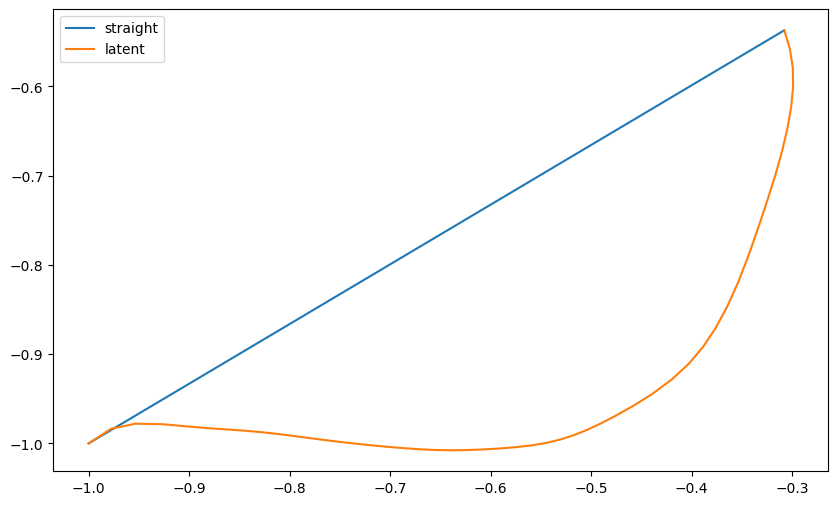

In [144]:
plt.figure(figsize=(10, 6))
plot_paths(PATHS)
# plot_accelerations(ALL_PATHS, scale=0.015, num=20, dt=0.001)
plt.show()

In [145]:
# straight_path.ambient_path.euclidean_length(0, 0.1)
straight_path.ambient_path.euclidean_length(0, 0.1, 0.001)
# straight_path.euclidean_length(0, 1, 0.0001)
# straight_path.euclidean_length(0, 1,)

0.8695881991209637

['straight', 'latent']


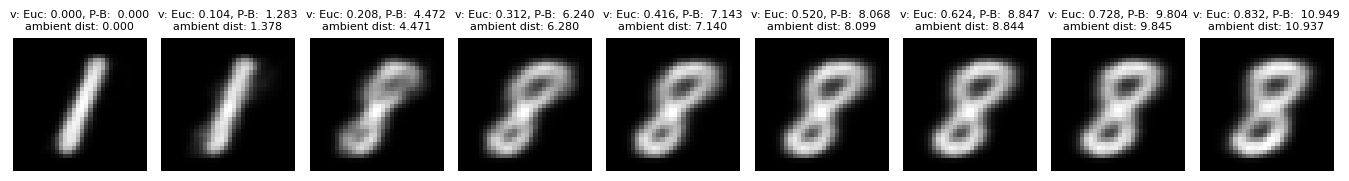

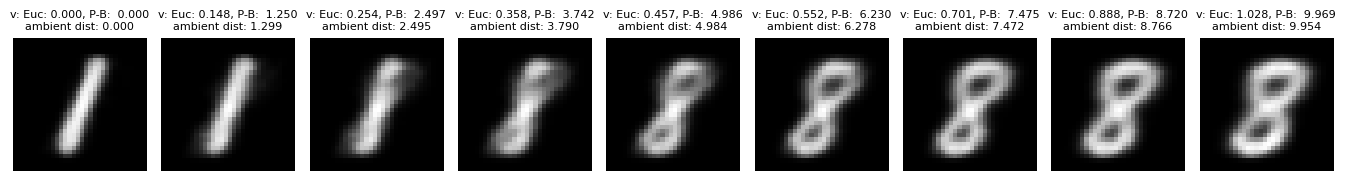

In [146]:
# pths = [(straight_path, "straight")] + SPIDER_PATHS
pths = PATHS
print([name for _, name in pths])
for path, name in pths:
    show_path_in_ambient(path, n_points=9)

In [147]:
fig_px = px.scatter(
    x=mus[:, 0].detach().cpu(),
    y=mus[:, 1].detach().cpu(),
    color=labels.numpy().astype(str),
    opacity=0.05,
)

In [151]:
background_trace

Scatter({
    'marker': {'color': array(['#109618', '#316395', '#316395', ..., '#990099', '#990099', '#DD4477'],
                              dtype=object),
               'opacity': 0.1},
    'mode': 'markers',
    'name': 'mnist',
    'x': array([ 0.2958818 ,  0.91143996,  1.0964764 , ...,  0.48778236,  0.9822036 ,
                -0.6947803 ], dtype=float32),
    'y': array([ 0.33440685, -1.0418792 ,  0.471361  , ...,  1.8205177 , -0.6285357 ,
                 1.2086709 ], dtype=float32)
})

In [156]:
fig.data[0]

Scatter({
    'marker': {'color': array(['#109618', '#316395', '#316395', ..., '#990099', '#990099', '#DD4477'],
                              dtype=object),
               'opacity': 0.1},
    'mode': 'markers',
    'name': 'mnist',
    'x': array([ 0.2958818 ,  0.91143996,  1.0964764 , ...,  0.48778236,  0.9822036 ,
                -0.6947803 ], dtype=float32),
    'y': array([ 0.33440685, -1.0418792 ,  0.471361  , ...,  1.8205177 , -0.6285357 ,
                 1.2086709 ], dtype=float32)
})

In [148]:
fig_px.data

(Scattergl({
     'hovertemplate': 'color=5<br>x=%{x}<br>y=%{y}<extra></extra>',
     'legendgroup': '5',
     'marker': {'color': '#636efa', 'opacity': 0.05, 'symbol': 'circle'},
     'mode': 'markers',
     'name': '5',
     'showlegend': True,
     'x': array([-0.36206782, -1.4024979 , -1.0803546 , ..., -0.889488  , -1.117884  ,
                  0.13029449], dtype=float32),
     'xaxis': 'x',
     'y': array([-0.29804856, -0.40367204, -0.41348696, ..., -0.23627535, -0.3310145 ,
                 -0.57967496], dtype=float32),
     'yaxis': 'y'
 }),
 Scattergl({
     'hovertemplate': 'color=0<br>x=%{x}<br>y=%{y}<extra></extra>',
     'legendgroup': '0',
     'marker': {'color': '#EF553B', 'opacity': 0.05, 'symbol': 'circle'},
     'mode': 'markers',
     'name': '0',
     'showlegend': True,
     'x': array([-1.7271957, -2.098212 , -1.5095625, ..., -1.9302806, -1.8567089,
                 -2.0557206], dtype=float32),
     'xaxis': 'x',
     'y': array([0.8829692 , 1.0088687 , 0.578411